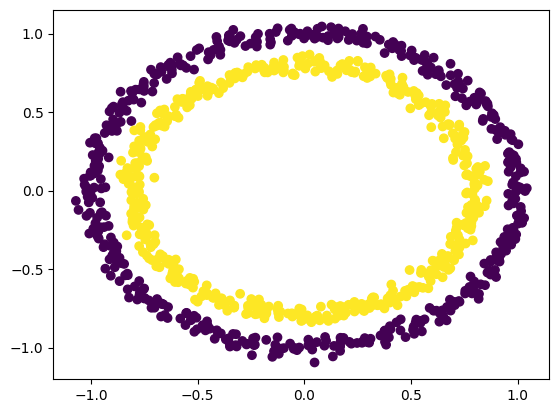

In [2]:
import torch
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=1001)

plt.scatter(
    X[:,0],  # this kind of indexing works because X y are numpy arrays
    X[:,1],
    c=y,
    cmap=plt.colormaps["viridis"]
)
plt.show()

## Examining Data
The data here is (# of samples/trg examples, # of features)

In [3]:
X.shape, y.shape
# X has 2 features, y has no features, is a scalar.

((1000, 2), (1000,))

In [4]:
X = torch.from_numpy(X).type(torch.float)  # numpy defaults to float64
y = torch.from_numpy(y).type(torch.float)  #.float is alias for float32

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1001)

from torch import nn
FORCE_CPU = False
DEVICE = 'cpu'
if torch.cuda.is_available() and not FORCE_CPU:
    DEVICE = 'cuda'
elif torch.backends.mps.is_available() and not FORCE_CPU:
    DEVICE = 'mps'

X_train = X_train.to(DEVICE)
y_train = y_train.to(DEVICE)
X_test = X_test.to(DEVICE)
y_test = y_test.to(DEVICE)

class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModel().to(DEVICE)

In [5]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(DEVICE)

# sequential is good for straightforward computation but...
# it ALWAYS runs ins sequential order

# If you want something else to happen then you'd have to build your own

Set up loss and optimizer
Binary cross entropy or categorical cross entropy

In [6]:
# set up loss function/ loss criterion which differs across types of problems (regression etc etc)
# optimizer function can be used for a range of problems like Adam optimizer / stochastic gradient descent
# loss_fn = nn.BCELoss() requires inputs to have gone through sigmoid function, though the option below has igher numerical stability
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [7]:
# Create evaluation metric (accuracy)
def accuracy_fn(y_true, y_pred):
    correct =  torch.eq(y_true, y_pred).sum().item()
    acc = correct/len(y_pred) * 100
    return acc


### Interlude
Understanding model outputs - logits/log-odds are output by the models. Then turn it back into prediction probabilities with sigmoid/softmax and apply a decision boundary to turn it into prediction labels

In [8]:
logits = model_0(X_test) # what the model spits out is log odds / logits
# The logit of a probability p logit(p) = ln(p/1-p)
# The inverse of a logit is the sigmoid function, this returns the actual prediction probabilities
pred_probs = torch.sigmoid(logits)

# For our prediction probabilities, we need to round to turn it into prediction labels
# ie prob >= 0.5 ? 1 : 0
preds = torch.round(pred_probs)


## Train the "model" ... ?

### Training loop steps
1. Forward pass - Model goes through all of the training data once, performing its `forward()` function calculations

2. Calculate loss - Model's outputs are compared to ground truth and evaluated to see how wrong they are.

`loss = loss_fn(y_pred, y_train)`

3. Zero gradients - optimizer gradients are set to zero so they can be recalculated fo the specific training step (`optimizer.zero_grad()`)

4. Perform backprop on loss - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with `requires_grad=True`). `loss_backward()`

5. Step the optimizer - update parameters with `require_grad=True` wrt loss gradients in order to improve them using `optimizer.step()`


In [9]:
torch.manual_seed(42)
epochs = 200

for epoch in range(epochs):
    model_0.train()
    y_logits = model_0(X_train).squeeze()  # why squeeze?
    y_preds = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    # BCEWithLogitsLoss expects raw logits and recomputes preds internally to compare with y_train
    acc = accuracy_fn(y_train, y_preds)
    loss.backward()
    optimizer.zero_grad()
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # Forward pass
        lgt = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(lgt))
        test_loss = loss_fn(lgt, y_test)
        test_acc = accuracy_fn(y_test, test_preds)

    if epoch%10==0:
        print(f"Loss = {test_loss}")
        print(f"accuracy: {test_acc}")

Loss = 0.7075369358062744
accuracy: 40.0
Loss = 0.7075369358062744
accuracy: 40.0
Loss = 0.7075369358062744
accuracy: 40.0
Loss = 0.7075369358062744
accuracy: 40.0
Loss = 0.7075369358062744
accuracy: 40.0
Loss = 0.7075369358062744
accuracy: 40.0
Loss = 0.7075369358062744
accuracy: 40.0
Loss = 0.7075369358062744
accuracy: 40.0
Loss = 0.7075369358062744
accuracy: 40.0
Loss = 0.7075369358062744
accuracy: 40.0
Loss = 0.7075369358062744
accuracy: 40.0
Loss = 0.7075369358062744
accuracy: 40.0
Loss = 0.7075369358062744
accuracy: 40.0
Loss = 0.7075369358062744
accuracy: 40.0
Loss = 0.7075369358062744
accuracy: 40.0
Loss = 0.7075369358062744
accuracy: 40.0
Loss = 0.7075369358062744
accuracy: 40.0
Loss = 0.7075369358062744
accuracy: 40.0
Loss = 0.7075369358062744
accuracy: 40.0
Loss = 0.7075369358062744
accuracy: 40.0


This model is crippled because it's essentially a linear model and cannot draw nonlinear decision boundaries. time to introduce nonlinearity

In [10]:
class CircleModelV1(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        # return self.relu(self.layer3(self.layer2(self.layer1(x))))
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_1 = CircleModelV1().to(DEVICE)

In [12]:
# set up loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(model_1.parameters(), lr=0.001)
torch.manual_seed(42)

# set up data if necessary (done above)

for epoch in range(2000):
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    optim.zero_grad()
    loss.backward()
    optim.step()
    

    ## Testing
    model_1.eval()
    with torch.inference_mode():
        y_test_logits = model_1(X_test).squeeze()
        y_test_preds = torch.round(torch.sigmoid(y_test_logits))
        test_loss = loss_fn(y_test_logits, y_test)
        test_acc = accuracy_fn(y_test, y_test_preds)
    if epoch%10 == 0:
        print(f"acc={test_acc}, loss={test_loss}")
    

acc=52.0, loss=0.692342221736908
acc=52.0, loss=0.6923402547836304
acc=52.0, loss=0.6923381090164185
acc=52.0, loss=0.6923357844352722
acc=52.0, loss=0.6923335194587708
acc=52.0, loss=0.692331075668335
acc=52.0, loss=0.6923286318778992
acc=52.0, loss=0.6923263669013977
acc=52.0, loss=0.6923239827156067
acc=52.0, loss=0.6923215985298157
acc=52.0, loss=0.692319393157959
acc=52.0, loss=0.6923171281814575
acc=52.0, loss=0.6923147439956665
acc=52.0, loss=0.692312479019165
acc=52.0, loss=0.692310094833374
acc=52.0, loss=0.692307710647583
acc=52.0, loss=0.6923054456710815
acc=52.0, loss=0.6923031210899353
acc=52.0, loss=0.6923008561134338
acc=52.0, loss=0.6922986507415771
acc=52.0, loss=0.6922963857650757
acc=52.0, loss=0.6922941207885742
acc=52.0, loss=0.6922919154167175
acc=52.0, loss=0.6922895908355713
acc=52.0, loss=0.6922871470451355
acc=52.0, loss=0.6922847628593445
acc=52.0, loss=0.6922823190689087
acc=52.0, loss=0.6922800540924072
acc=52.0, loss=0.692277729511261
acc=52.0, loss=0.6922

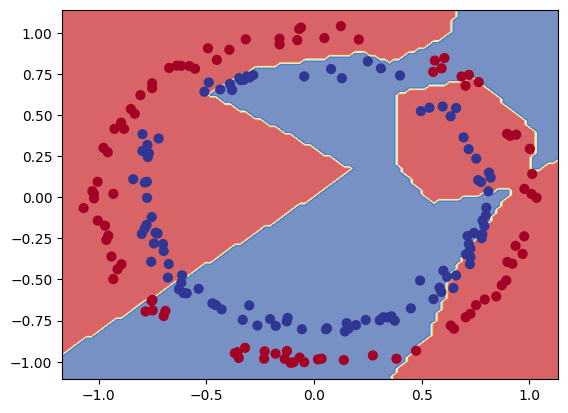

In [13]:
# Plot decision boundary
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
plot_decision_boundary(model_1, X_test, y_test)

> Multimodal clf

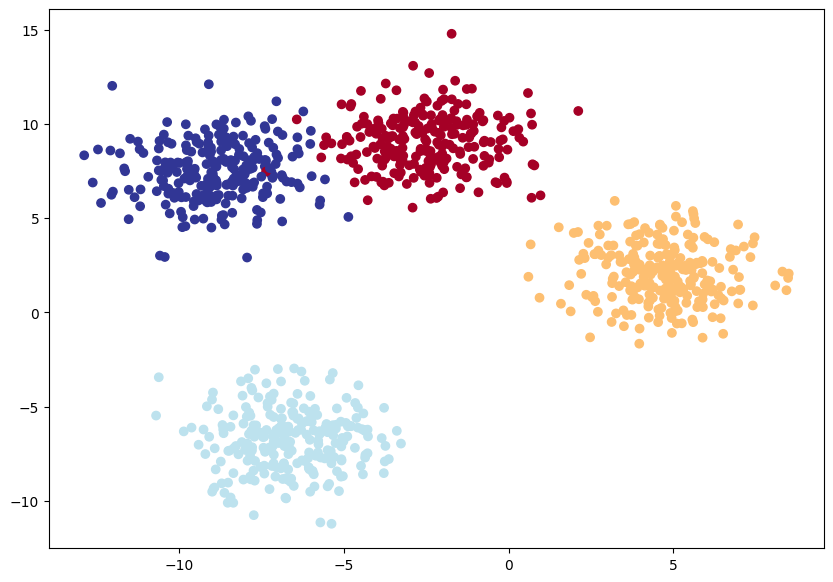

In [14]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# hyperparams (input features)
NUM_CLASSES = 4
NUM_FEATURES = 2

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=42) # seed

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Partition into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        train_size=0.8,
                                                                        random_state=42)

# Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1],c=y_blob, cmap='RdYlBu')
plt.show()


In [15]:
DEVICE = "cpu"
FORCE_CPU = False
if not FORCE_CPU and torch.cuda.is_available():
    DEVICE = "cuda"
elif not FORCE_CPU and torch.backends.mps.is_available():
    DEVICE = "mps"

DEVICE

'mps'

In [16]:
X_blob_test, X_blob_train = X_blob_test.to(DEVICE), X_blob_train.to(DEVICE)
y_blob_test, y_blob_train = y_blob_test.to(DEVICE), y_blob_train.to(DEVICE)

In [17]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8) -> None:
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.layer_stack(x)

blob_model_0 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES).to(DEVICE)

In [18]:
# Create loss function and optimizer
blob_loss_fn = nn.CrossEntropyLoss()
blob_optim = torch.optim.SGD(params=blob_model_0.parameters(), lr=0.1)

## Prediction probabilities
For a binary clf, you'd need to use a sigmoid function to get the probabilities from logits.
For a multiclass clf, you'd need to use the softmax function to get the probabilities

In [19]:
## Getting prediction probabilities
blob_model_0.eval()

with torch.inference_mode():
    blob_logits = blob_model_0(X_blob_test.to(DEVICE)) # raw logit outputs
    blob_pred_probs = torch.softmax(blob_logits, dim=1)


In [20]:
def accuracy_fn(y_test, y_preds):
    # Count the number of correct predictions
    return torch.eq(y_test, y_preds).sum().item()/len(y_test)

In [23]:
# Train the model
torch.manual_seed(42)
epochs = 200
for epoch in range(epochs):
    blob_model_0.train()
    trg_logits = blob_model_0(X_blob_train.to(DEVICE))
    trg_preds= torch.softmax(trg_logits, dim=1).argmax(dim=1) # somehow don't need softmax?
    loss = blob_loss_fn(trg_logits, y_blob_train)
    blob_optim.zero_grad()
    loss.backward()
    blob_optim.step()

    blob_model_0.eval()
    test_preds = torch.argmax(blob_model_0(X_blob_test.to(DEVICE)))
    torch.eq(test_preds, y_blob_test)


In [24]:
blob_model_0.eval()
test_logits = blob_model_0(X_blob_test.to(DEVICE))
test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
test_loss = blob_loss_fn(test_logits, y_blob_test)
test_acc = accuracy_fn(y_blob_test, test_preds)

In [37]:
y_blob.unsqueeze(dim=0)

tensor([[3, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 3, 0, 2, 2, 2, 0, 0, 0, 1, 1, 3, 3, 3,
         1, 1, 0, 0, 2, 1, 2, 2, 2, 0, 0, 3, 2, 1, 3, 3, 1, 2, 1, 3, 1, 3, 0, 1,
         3, 1, 2, 0, 1, 3, 0, 3, 0, 0, 0, 2, 2, 0, 2, 3, 1, 0, 2, 2, 1, 0, 3, 0,
         1, 2, 1, 3, 1, 0, 1, 0, 2, 0, 0, 0, 1, 3, 2, 2, 0, 0, 0, 0, 1, 1, 3, 1,
         3, 0, 1, 2, 1, 3, 3, 0, 3, 1, 1, 0, 2, 0, 3, 2, 1, 1, 1, 1, 2, 3, 2, 1,
         0, 2, 3, 1, 3, 2, 1, 3, 2, 1, 0, 2, 1, 3, 1, 3, 0, 2, 1, 1, 0, 0, 3, 3,
         3, 1, 1, 0, 0, 0, 0, 3, 2, 2, 0, 1, 0, 1, 1, 3, 2, 0, 1, 2, 0, 0, 1, 2,
         3, 2, 1, 0, 0, 1, 0, 3, 2, 3, 2, 3, 1, 1, 0, 2, 0, 2, 1, 3, 0, 2, 1, 0,
         1, 1, 0, 3, 2, 2, 2, 3, 0, 2, 1, 0, 1, 1, 2, 0, 1, 2, 2, 3, 2, 2, 1, 0,
         2, 0, 3, 1, 3, 3, 2, 0, 3, 0, 1, 2, 2, 0, 0, 2, 0, 3, 2, 2, 3, 2, 2, 1,
         2, 3, 2, 1, 3, 0, 1, 0, 1, 1, 1, 1, 3, 1, 1, 2, 0, 2, 2, 1, 1, 1, 3, 1,
         3, 3, 2, 1, 0, 3, 1, 0, 1, 2, 0, 3, 1, 3, 2, 1, 3, 2, 3, 1, 2, 0, 0, 2,
         0, 3, 3, 0, 2, 2, 2

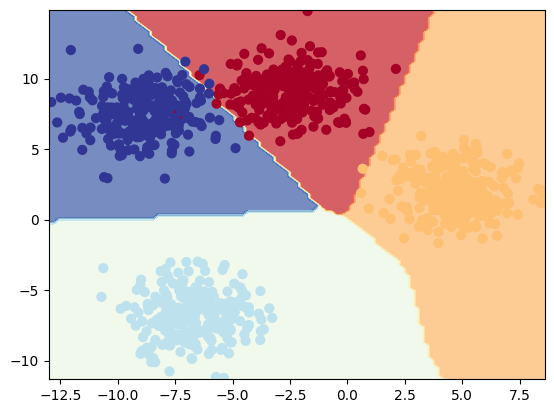

In [39]:
plot_decision_boundary(blob_model_0, X_blob, y_blob.unsqueeze(dim=0))

## Torchmetrics
Import torchmetrics and then load the metric object onto desired device

In [28]:
from torchmetrics import Accuracy

# Setup metric
accuracy = Accuracy(task="multiclass",num_classes=NUM_CLASSES).to(DEVICE)
# check online for arguments

# Calculate accuracy
accuracy(test_preds, y_blob_test)

tensor(0.9950, device='mps:0')